In [ ]:
import os
import sys

# Set up environment variables
os.environ['HADOOP_HOME'] = '/hadoop'
os.environ['SPARK_HOME'] = '/spark'
sys.path.append('/spark/python')
sys.path.append('/spark/python/lib/py4j-0.10.9.7-src.zip')

# Add PySpark to sys.path
spark_path = os.environ['SPARK_HOME'] + '/python'
sys.path.insert(0, spark_path)


In [2]:
from pyspark.sql import SparkSession, Window
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, expr, from_json, explode, size, sum, count, rank, rand
from pyspark.sql.types import StructType, StructField, StringType, ArrayType, DateType, ByteType, DoubleType, IntegerType
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
spark = (SparkSession
    .builder 
    .appName("Goodreads Project") 
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") 
    .getOrCreate())

In [4]:
if 'spark' in locals() and isinstance(spark, SparkSession):
    print("SparkSession is active and ready to use.")
else:
    print("SparkSession is not active. Please create a SparkSession.")

SparkSession is active and ready to use.


In [5]:
sc = spark.sparkContext

In [6]:
sc

<SparkContext master=yarn appName=Goodreads Project>

In [7]:
df = (spark.read.format("csv") 
    .option("inferschema", "true") 
    .option("sep", "\t") 
    .option("header", "true") 
    .load("hdfs://localhost:9000/data/books.tsv")
     )

In [8]:
df.printSchema()

root
 |-- url: string (nullable = true)
 |-- data: string (nullable = true)



# The Data
## Exploring the data

The data column is a JSON that is stored in a **string**, but the string contains **escaped quotes**.

Steps to parse the data to a standard dataFrame:
1. Remove surrounding quotes
2. Replace the escaped double quotes with actual quotes

In [10]:
df.select("data").first()

Row(data='"{""isbn"": null, ""title"": ""Harry Potter and the Half-Blood Prince"", ""format"": null, ""authors"": [{""url"": ""https://www.goodreads.com/author/show/1077326.J_K_Rowling"", ""name"": ""J.K. Rowling""}], ""reviews"": [{""url"": ""https://www.goodreads.com/review/show/683662307"", ""date"": ""Aug 01, 2013"", ""text"": ""(A) 86% | Extraordinary Notes: It dwells on the delightfully mundane aspects of the magical world, and adds new dimensions to familiar characters."", ""user"": {""url"": ""/user/show/22106879-jayson"", ""name"": ""Jayson""}, ""rating"": 5.0, ""bookUrl"": ""http://www.goodreads.com/book/show/1.harry_potter_and_the_half_blood_prince.warc"", ""shelves"": [{""url"": ""/review/list/22106879-jayson?shelf=author-british"", ""name"": ""author-british""}, {""url"": ""/review/list/22106879-jayson?shelf=format-illustrated"", ""name"": ""format-illustrated""}, {""url"": ""/review/list/22106879-jayson?shelf=subject-boarding-school"", ""name"": ""subject-boarding-school"

### Fix the JSON string in the data column
1. Remove surrounding quotes
2. Replace escaped quotes with normal quotes
> **Regex pattern:** \
> Removes outer quotes and replaces double double quotes


In [12]:
json_data = df.withColumn("json_data", expr("regexp_replace(regexp_replace(data, '^\"|\"$', ''), '\"\"', '\"')"))

In [13]:
json_data.show(1)

+--------------------+--------------------+--------------------+
|                 url|                data|           json_data|
+--------------------+--------------------+--------------------+
|http://www.goodre...|"{""isbn"": null,...|{"isbn": null, "t...|
+--------------------+--------------------+--------------------+
only showing top 1 row



In [14]:
json_data.select("json_data").first()[0]

'{"isbn": null, "title": "Harry Potter and the Half-Blood Prince", "format": null, "authors": [{"url": "https://www.goodreads.com/author/show/1077326.J_K_Rowling", "name": "J.K. Rowling"}], "reviews": [{"url": "https://www.goodreads.com/review/show/683662307", "date": "Aug 01, 2013", "text": "(A) 86% | Extraordinary Notes: It dwells on the delightfully mundane aspects of the magical world, and adds new dimensions to familiar characters.", "user": {"url": "/user/show/22106879-jayson", "name": "Jayson"}, "rating": 5.0, "bookUrl": "http://www.goodreads.com/book/show/1.harry_potter_and_the_half_blood_prince.warc", "shelves": [{"url": "/review/list/22106879-jayson?shelf=author-british", "name": "author-british"}, {"url": "/review/list/22106879-jayson?shelf=format-illustrated", "name": "format-illustrated"}, {"url": "/review/list/22106879-jayson?shelf=subject-boarding-school", "name": "subject-boarding-school"}, {"url": "/review/list/22106879-jayson?shelf=genre-juvenile-fantasy", "name": "ge

### Parse the fixed JSON string into a structured DataFrame
**selectExpr**: 
> allows you to perform operations on your DataFrame using SQL like expressions.

**from_json**: converts json string into corresponding object or data structure
> it deserializes a JSON string, meaning it interprets the text as data that can be used in your app.

In [16]:
j_string = json_data.select("json_data").first()[0]
parsed_dict = json.loads(j_string)


In [17]:
parsed_dict

{'isbn': None,
 'title': 'Harry Potter and the Half-Blood Prince',
 'format': None,
 'authors': [{'url': 'https://www.goodreads.com/author/show/1077326.J_K_Rowling',
   'name': 'J.K. Rowling'}],
 'reviews': [{'url': 'https://www.goodreads.com/review/show/683662307',
   'date': 'Aug 01, 2013',
   'text': '(A) 86% | Extraordinary Notes: It dwells on the delightfully mundane aspects of the magical world, and adds new dimensions to familiar characters.',
   'user': {'url': '/user/show/22106879-jayson', 'name': 'Jayson'},
   'rating': 5.0,
   'bookUrl': 'http://www.goodreads.com/book/show/1.harry_potter_and_the_half_blood_prince.warc',
   'shelves': [{'url': '/review/list/22106879-jayson?shelf=author-british',
     'name': 'author-british'},
    {'url': '/review/list/22106879-jayson?shelf=format-illustrated',
     'name': 'format-illustrated'},
    {'url': '/review/list/22106879-jayson?shelf=subject-boarding-school',
     'name': 'subject-boarding-school'},
    {'url': '/review/list/2210687

In [18]:
# import json

# with open("parsed_output.json", "w") as file:
#     json.dump(parsed_dict, file, indent=4)


In [19]:
for key, value in parsed_dict.items():
    if isinstance(value, list):
        for i in range(len(value)):
            counter = 0
            for s_key, s_value in value[i-1].items():
                counter += 1
                print(f"\t{counter}: {s_key}", end="\n")
            print()

    print(f"{key}\n")

isbn

title

format

	1: url
	2: name

authors

	1: url
	2: date
	3: text
	4: user
	5: rating
	6: bookUrl
	7: shelves

	1: url
	2: date
	3: text
	4: user
	5: rating
	6: bookUrl
	7: shelves

	1: url
	2: date
	3: text
	4: user
	5: rating
	6: bookUrl
	7: shelves

	1: url
	2: date
	3: text
	4: user
	5: rating
	6: bookUrl
	7: shelves

	1: url
	2: date
	3: text
	4: user
	5: rating
	6: bookUrl
	7: shelves

	1: url
	2: date
	3: text
	4: user
	5: rating
	6: bookUrl
	7: shelves

	1: url
	2: date
	3: text
	4: user
	5: rating
	6: bookUrl
	7: shelves

	1: url
	2: date
	3: text
	4: user
	5: rating
	6: bookUrl
	7: shelves

	1: url
	2: date
	3: text
	4: user
	5: rating
	6: bookUrl
	7: shelves

	1: url
	2: date
	3: text
	4: user
	5: rating
	6: bookUrl
	7: shelves

	1: url
	2: date
	3: text
	4: user
	5: rating
	6: bookUrl
	7: shelves

	1: url
	2: date
	3: text
	4: user
	5: rating
	6: bookUrl
	7: shelves

	1: url
	2: date
	3: text
	4: user
	5: rating
	6: bookUrl
	7: shelves

	1: url
	2: date
	3: text
	4:

In [20]:
list(parsed_dict.keys())

['isbn',
 'title',
 'format',
 'authors',
 'reviews',
 'language',
 'numPages',
 'seriesUrl',
 'numRatings',
 'numReviews',
 'description',
 'averageRating',
 'seriesAndOrdinal',
 'otherEditionsLink',
 'publicationDetails']

# Selecting columns from the dataset
#### Defining the Schema
isbn \
title \
format
1. url
2. name
   
authors
1. url 
2. date 
3. text 
4. user
5. rating
6. bookUrl
7. shelves
 
reviews \
language \
numPages \
seriesUrl \
numRatings \
numReviews \
description \
averageRating \
seriesAndOrdinal \
otherEditionsLink \
publicationDetails


In [22]:
# Define schema for JSON
schema = StructType([
    StructField("isbn", StringType(), True),
    StructField("title", StringType(), True),
    StructField("authors", ArrayType(StructType([
        StructField("url", StringType(), True),
        StructField("name", StringType(), True),
    ])), True),
    StructField("reviews", ArrayType(StructType([
        StructField("url", StringType(), True),
        StructField("date", StringType(), True),
        StructField("text", StringType(), True),
        StructField("user", StructType([
            StructField("url", StringType(), True), 
            StructField("name", StringType(), True),
        ]), True),
        StructField("rating", DoubleType(), True),
        StructField("bookUrl", StringType(), True),
    ])), True),
    StructField("language", StringType(), True),
    StructField("numPages", DoubleType(), True),
    StructField("seriesUrl", StringType(), True),
    StructField("numRatings", DoubleType(), True),
    StructField("numReviews", StringType(), True),
    StructField("description", StringType(), True),
    StructField("averageRating", StringType(), True),
    StructField("seriesAndOrdinal", StringType(), True),    
])

In [23]:
parsed_df = json_data.selectExpr(f"from_json(json_data, '{schema.simpleString()}') as parsed_data")

In [24]:
parsed_df.printSchema()

root
 |-- parsed_data: struct (nullable = true)
 |    |-- isbn: string (nullable = true)
 |    |-- title: string (nullable = true)
 |    |-- authors: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- url: string (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |-- reviews: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- url: string (nullable = true)
 |    |    |    |-- date: string (nullable = true)
 |    |    |    |-- text: string (nullable = true)
 |    |    |    |-- user: struct (nullable = true)
 |    |    |    |    |-- url: string (nullable = true)
 |    |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- rating: double (nullable = true)
 |    |    |    |-- bookUrl: string (nullable = true)
 |    |-- language: string (nullable = true)
 |    |-- numPages: double (nullable = true)
 |    |-- seriesUrl: string (nullable = true)
 |    |-- numRating

In [25]:
parsed_df.show(10)

+--------------------+
|         parsed_data|
+--------------------+
|{NULL, Harry Pott...|
|{9780439785969, H...|
|{NULL, Harry Pott...|
|{NULL, Harry Pott...|
|{NULL, Harry Pott...|
|{9780439785969, H...|
|{9780439827607, H...|
|{9780439827607, H...|
|{9781581805635, S...|
|{9780761458050, H...|
+--------------------+
only showing top 10 rows



In [26]:
v = parsed_df.limit(30).toPandas()
print(v)

                                          parsed_data
0   (None, Harry Potter and the Half-Blood Prince,...
1   (9780439785969, Harry Potter and the Half-Bloo...
2   (None, Harry Potter and the Half-Blood Prince,...
3   (None, Harry Potter and the Half-Blood Prince,...
4   (None, Harry Potter and the Half-Blood Prince,...
5   (9780439785969, Harry Potter and the Half-Bloo...
6   (9780439827607, Harry Potter Collection, [(htt...
7   (9780439827607, Harry Potter Collection, [(htt...
8   (9781581805635, Simply Beautiful Beading: 53 Q...
9   (9780761458050, How to Teach a Slug to Read, [...
10  (9781455814244, Warmth of Other Suns, The: The...
11  (9781441786258, What Women Want: The Global Ma...
12  (9788497932806, Una pasion Indomable, [(https:...
13  (9780984502202, Yellow Crocus, [(https://www.g...
14  (9780984502202, Yellow Crocus, [(https://www.g...
15  (B003AYEMX4, Treacherous Moon, [(https://www.g...
16  (9789774215001, الغجر وأعمال أخرى, [(https://w...
17  (9784906574735, Making G

In [27]:
# parsed_df.limit(100).toPandas().to_csv("output.csv", index=False)

In [28]:
# Extract individual fields into their own columns
# final_df = parsed_df.selectExpr("parsed_data.isbn", "parsed_data.title", "parsed_data.format", "parsed_data.format.url", "parsed_data.format.name", 
#                                "parsed_data.authors", "parsed_data.authors.url", "parsed_data.authors.date", "parsed_data.authors.text",
#                                 "parsed_data.authors.user", "parsed_data.authors.rating", "parsed_data.authors.bookUrl", "parsed_data.authors.shelves",
#                                "parsed_data.reviews", "parsed_data.language", "parsed_data.numPages", "parsed_data.seriesUrl", "parsed_data.numRatings",
#                                "parsed_data.numReviews", "parsed_data.description", "parsed_data.averageRating", "parsed_data.seriesAndOrdinal",
#                                 "parsed_data.publicationDetails")
final_df = parsed_df.selectExpr("parsed_data.*")

In [29]:
final_df.show(1)

+----+--------------------+--------------------+--------------------+--------+--------+--------------------+----------+----------+--------------------+-------------+-----------------+
|isbn|               title|             authors|             reviews|language|numPages|           seriesUrl|numRatings|numReviews|         description|averageRating| seriesAndOrdinal|
+----+--------------------+--------------------+--------------------+--------+--------+--------------------+----------+----------+--------------------+-------------+-----------------+
|NULL|Harry Potter and ...|[{https://www.goo...|[{https://www.goo...| English|   652.0|/series/45175-har...| 2861252.0|     47883|The war against V...|         4.57|(Harry Potter #6)|
+----+--------------------+--------------------+--------------------+--------+--------+--------------------+----------+----------+--------------------+-------------+-----------------+
only showing top 1 row



In [30]:
# final_df.limit(200).toPandas().to_csv("final_output.csv", index=False)

In [31]:
# final_df.count()

In [32]:
# final_df.explain()

In [33]:
num_partitions = final_df.rdd.getNumPartitions()
num_partitions

127

In [34]:
final_df_limited = parsed_df.select(
    col("parsed_data.isbn").alias("isbn"),
    col("parsed_data.title").alias("title"),
    col("parsed_data.averageRating").alias("Avg.rating"),
    col("parsed_data.numPages").alias("numberOfpages"),
    col("parsed_data.language").alias("language"),
    col("parsed_data.numRatings").alias("numOfRatings"),
    col("parsed_data.numReviews").alias("numOfReviews"),
    col("parsed_data.authors.name").alias("authorName"),
    col("parsed_data.reviews.user.name").alias("userNames"),
    col("parsed_data.reviews.user.url").alias("userUrls"),
    col("parsed_data.reviews.rating").alias("userRatings"),
    col("parsed_data.reviews.bookUrl").alias("bookUrl"),
)

In [35]:
final_df_limited.show(7, truncate=10)

+----------+----------+----------+-------------+--------+------------+------------+----------+----------+----------+-----------+----------+
|      isbn|     title|Avg.rating|numberOfpages|language|numOfRatings|numOfReviews|authorName| userNames|  userUrls|userRatings|   bookUrl|
+----------+----------+----------+-------------+--------+------------+------------+----------+----------+----------+-----------+----------+
|      NULL|Harry P...|      4.57|        652.0| English|   2861252.0|       47883|[J.K. R...|[Jayson...|[/user/...| [5.0, 5...|[http:/...|
|9780439...|Harry P...|      4.57|        652.0| English|   2259210.0|       35863|[J.K. R...|[C.G. D...|[/user/...| [5.0, 5...|[http:/...|
|      NULL|Harry P...|      4.57|        652.0| English|   2419016.0|       39173|[J.K. R...|[Whitne...|[/user/...| [5.0, 5...|[http:/...|
|      NULL|Harry P...|      4.57|        652.0| English|   2683533.0|       44073|[J.K. R...|[Jayson...|[/user/...| [5.0, 5...|[http:/...|
|      NULL|Harry P.

In [36]:
pandas_df = final_df_limited.limit(7).toPandas()
pandas_df

,isbn,title,Avg.rating,numberOfpages,language,numOfRatings,numOfReviews,authorName,userNames,userUrls,userRatings,bookUrl
0,None,Harry Potter and the Half-Blood Prince,4.57,652.0,English,2861252.0,47883,[J.K. Rowling],"[Jayson, Whitney Atkinson, Jayson, ❀ Lily ❀, T...","[/user/show/22106879-jayson, /user/show/144571...","[5.0, 5.0, 5.0, None, 5.0, None, 5.0, 5.0, 5.0...",[http://www.goodreads.com/book/show/1.harry_po...
1,9780439785969,Harry Potter and the Half-Blood Prince,4.57,652.0,English,2259210.0,35863,[J.K. Rowling],"[C.G. Drews, Whitney Atkinson, Jayson, Lily C,...","[/user/show/11375137-c-g-drews, /user/show/144...","[5.0, 5.0, 5.0, None, 5.0, 5.0, 5.0, 5.0, 5.0,...",[http://www.goodreads.com/book/show/1.harry_po...
2,None,Harry Potter and the Half-Blood Prince,4.57,652.0,English,2419016.0,39173,[J.K. Rowling],"[Whitney Atkinson, Jayson, Jayson, Lily C, C.G...","[/user/show/14457130-whitney-atkinson, /user/s...","[5.0, 5.0, 5.0, None, None, 5.0, None, 5.0, 5....",[http://www.goodreads.com/book/show/1.harry_po...
3,None,Harry Potter and the Half-Blood Prince,4.57,652.0,English,2683533.0,44073,[J.K. Rowling],"[Jayson, Whitney Atkinson, Jayson, LilyCReads,...","[/user/show/22106879-jayson, /user/show/144571...","[5.0, 5.0, 5.0, None, 5.0, 5.0, 5.0, None, 5.0...",[http://www.goodreads.com/book/show/1.harry_po...
4,None,Harry Potter and the Half-Blood Prince,4.57,652.0,English,2623552.0,42940,[J.K. Rowling],"[Jayson, Whitney Atkinson, Jayson, LilyCReads,...","[/user/show/22106879-jayson, /user/show/144571...","[5.0, 5.0, 5.0, None, 5.0, 5.0, None, 5.0, 5.0...",[http://www.goodreads.com/book/show/1.harry_po...
5,9780439785969,Harry Potter and the Half-Blood Prince,4.56,652.0,English,2087194.0,33639,[J.K. Rowling],"[C.G. Drews, Whitney Atkinson, Jayson, Adam Si...","[/user/show/11375137-c-g-drews, /user/show/144...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",[http://www.goodreads.com/book/show/1.harry_po...
6,9780439827607,Harry Potter Collection,4.73,3342.0,English,29681.0,922,[J.K. Rowling],"[Ida, Jen Holman, Stephen, Jennifer Dater, Hen...","[/user/show/23173697-ida, /user/show/1767810-j...","[None, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0,...",[http://www.goodreads.com/book/show/10.harry_p...


In [37]:
collab_df = parsed_df.select(
    col("parsed_data.isbn").alias("isbn"),
    col("parsed_data.title").alias("title"),
    col("parsed_data.numPages").alias("numberOfpages"),
    col("parsed_data.averageRating").alias("Avg.rating"),
    col("parsed_data.authors.name").alias("authorName"),
    col("parsed_data.reviews.user.name").alias("userNames"),
    col("parsed_data.reviews.user.url").alias("userUrls"),
    col("parsed_data.reviews.rating").alias("userRatings"),
)

In [38]:
collab_df.show(15, truncate=10)

+----------+----------+-------------+----------+----------+----------+----------+-----------+
|      isbn|     title|numberOfpages|Avg.rating|authorName| userNames|  userUrls|userRatings|
+----------+----------+-------------+----------+----------+----------+----------+-----------+
|      NULL|Harry P...|        652.0|      4.57|[J.K. R...|[Jayson...|[/user/...| [5.0, 5...|
|9780439...|Harry P...|        652.0|      4.57|[J.K. R...|[C.G. D...|[/user/...| [5.0, 5...|
|      NULL|Harry P...|        652.0|      4.57|[J.K. R...|[Whitne...|[/user/...| [5.0, 5...|
|      NULL|Harry P...|        652.0|      4.57|[J.K. R...|[Jayson...|[/user/...| [5.0, 5...|
|      NULL|Harry P...|        652.0|      4.57|[J.K. R...|[Jayson...|[/user/...| [5.0, 5...|
|9780439...|Harry P...|        652.0|      4.56|[J.K. R...|[C.G. D...|[/user/...| [5.0, 5...|
|9780439...|Harry P...|       3342.0|      4.73|[J.K. R...|[Ida, J...|[/user/...| [NULL, ...|
|9780439...|Harry P...|       3342.0|      4.73|[J.K. R...|[

### Detecting early duplicates in the dataset

In [40]:
collab_df.select("title").show(8, truncate=False)

+--------------------------------------+
|title                                 |
+--------------------------------------+
|Harry Potter and the Half-Blood Prince|
|Harry Potter and the Half-Blood Prince|
|Harry Potter and the Half-Blood Prince|
|Harry Potter and the Half-Blood Prince|
|Harry Potter and the Half-Blood Prince|
|Harry Potter and the Half-Blood Prince|
|Harry Potter Collection               |
|Harry Potter Collection               |
+--------------------------------------+
only showing top 8 rows



### Dropping inital duplicates to reduce the size of the dataset

In [42]:
new_collab_df = collab_df.dropDuplicates()

In [43]:
new_collab_df.cache()

DataFrame[isbn: string, title: string, numberOfpages: double, Avg.rating: string, authorName: array<string>, userNames: array<string>, userUrls: array<string>, userRatings: array<double>]

In [44]:
new_collab_df.show(5)

+-------------+--------------------+-------------+----------+------------------+--------------------+--------------------+--------------------+
|         isbn|               title|numberOfpages|Avg.rating|        authorName|           userNames|            userUrls|         userRatings|
+-------------+--------------------+-------------+----------+------------------+--------------------+--------------------+--------------------+
|9781101478288|How to Be a Menta...|        256.0|      3.71|  [Simon Winthrop]|[Billy, Nick, Kel...|[/user/show/49121...|[1.0, 1.0, 1.0, 4...|
|9780679738954|   The Age of Reason|        408.0|      3.98|[Jean-Paul Sartre]|[melissa, Manny, ...|[/user/show/26694...|[4.0, 5.0, 4.0, 4...|
|9780670061792|                Epic|        384.0|      3.95|   [Conor Kostick]|[Kyle, Karin, Ski...|[/user/show/52906...|[NULL, 4.0, 2.0, ...|
|9780470181416|The Battle Over t...|        256.0|       3.0|     [Gordy Slack]|[Genelina Rivera,...|[/user/show/45115...|         [3.0,

In [45]:
new_collab_df.printSchema()

root
 |-- isbn: string (nullable = true)
 |-- title: string (nullable = true)
 |-- numberOfpages: double (nullable = true)
 |-- Avg.rating: string (nullable = true)
 |-- authorName: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- userNames: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- userUrls: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- userRatings: array (nullable = true)
 |    |-- element: double (containsNull = true)



In [46]:
new_collab_df.show(5)

+-------------+--------------------+-------------+----------+------------------+--------------------+--------------------+--------------------+
|         isbn|               title|numberOfpages|Avg.rating|        authorName|           userNames|            userUrls|         userRatings|
+-------------+--------------------+-------------+----------+------------------+--------------------+--------------------+--------------------+
|9781101478288|How to Be a Menta...|        256.0|      3.71|  [Simon Winthrop]|[Billy, Nick, Kel...|[/user/show/49121...|[1.0, 1.0, 1.0, 4...|
|9780679738954|   The Age of Reason|        408.0|      3.98|[Jean-Paul Sartre]|[melissa, Manny, ...|[/user/show/26694...|[4.0, 5.0, 4.0, 4...|
|9780670061792|                Epic|        384.0|      3.95|   [Conor Kostick]|[Kyle, Karin, Ski...|[/user/show/52906...|[NULL, 4.0, 2.0, ...|
|9780470181416|The Battle Over t...|        256.0|       3.0|     [Gordy Slack]|[Genelina Rivera,...|[/user/show/45115...|         [3.0,

In [47]:
new_collab_df.count()

398339

Detected: 
1. Duplicates still exist after the initial duplicate drop.
   - Probably due to a difference in an instances features. 
3. Duplicates in different languages -> Which may not be an issue


In [49]:
filtered_df = new_collab_df.filter(
    (col("title").startswith("Harry")) | (col("title") == "Harry Potter")
)

In [50]:
filtered_df.select("title").show(200, truncate=False)

+-----------------------------------------------------------------------------------------------------------------+
|title                                                                                                            |
+-----------------------------------------------------------------------------------------------------------------+
|Harry Potter e il Principe Mezzosangue                                                                           |
|Harry Potter and the Half-Blood Prince                                                                           |
|Harry Potter E A Pedra Filosofal: Livro Pôster                                                                   |
|Harry Potter and the Prisoner of Azkaban                                                                         |
|Harry Potter and the Sorcerer's Stone                                                                            |
|Harry Potter and the Sorcerer's Stone: MinaLima Edition (Harry Potter, 

In [51]:
filtered_df.show()

+-------------+--------------------+-------------+----------+------------------+--------------------+--------------------+--------------------+
|         isbn|               title|numberOfpages|Avg.rating|        authorName|           userNames|            userUrls|         userRatings|
+-------------+--------------------+-------------+----------+------------------+--------------------+--------------------+--------------------+
|9788867156009|Harry Potter e il...|        567.0|      4.57|    [J.K. Rowling]|[Whitney Atkinson...|[/user/show/14457...|[5.0, 5.0, 5.0, N...|
|9780545582995|Harry Potter and ...|        652.0|      4.57|    [J.K. Rowling]|[Whitney Atkinson...|[/user/show/14457...|[5.0, 5.0, 5.0, N...|
|9788588771017|Harry Potter E A ...|         NULL|      4.38| [Rocco Promocoes]|[Ana Pessoa, Brun...|[/user/show/33068...|[1.0, 5.0, 5.0, 5...|
|9780439136358|Harry Potter and ...|        435.0|      4.57|    [J.K. Rowling]|[Inge, Zoë, Wil W...|[/user/show/62788...|[5.0, 5.0, 4.0

Checking if userNames and userRatings are equal in size. 

In [53]:
single_instance_length = filtered_df.select(
    size(col("userNames")).alias("uN_length"),
    size(col("userRatings")).alias("uR_length")
).first()

print("Username: ",single_instance_length["uN_length"])
print("UserRating: ",single_instance_length["uR_length"])

Username:  30
UserRating:  30


In [54]:
single_instance = filtered_df.select(
    col("userNames"),
    col("userRatings")
).first()

In [55]:
single_instance

Row(userNames=['Whitney Atkinson', 'Jayson', 'Jayson', 'C.G. Drews', 'Lily C', 'Adam Silvera', 'Kai', 'Chelsea Humphrey', 'Aloysius', 'Sean Barrs ', 'Melissa ♥ Dog/Wolf Lover ♥ Martin', 'Chris', 'Merphy Napier', 'Reynita Maharani ★ The Night Reader ★', 'Jonathan Janz', 'Kassidy', 'Luca Ambrosino', 'Ahmad Sharabiani', ' Teodora ', 'emma', 'Hamad', 'Luffy', 'Chloe', 'Aj the Ravenous Reader', 'Warda', 'Tina ➹ the girl who lives in Fandoms ', 'April', 'Inge', 'April (Aprilius Maximus)', 'Evgeny'], userRatings=[5.0, 5.0, 5.0, None, None, 5.0, None, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0])

# Data preprocessing
0. Check that userNames list and userRatings list are matching in length. 
1. Data stored in lists:
   - userNames and userRatings stored in lists
2. Handle missing or Null values
   - Instances with missing userRatings should be removed
3. Handle duplicates
   - There should only be one user-item combination
    
# Feature engineering
4. Prepare matrix
   - user, item, rating
5. Popularity
   - Select the 1000 most popular items
   - Filter the data to consist of users that have ranked 5 or more items
6. Split data into train and test sets

# Model creation
7. Build model
8. Generate predictions


### 1. Expanding the lists so user-rating pairs are formed as instances. 

In [58]:
df_expanded = new_collab_df.select(
    col("isbn"),
    col("title"),
    col("authorName"),
    col("userNames").alias("userName_list"),
    col("userRatings").alias("userRating_list"),
).withColumn("userName", explode(col("userName_list"))) \
 .withColumn("userRating", explode(col("userRating_list")))

df_expanded = df_expanded.drop("userName_list", "userRating_list")

In [59]:
df_expanded.show(5)

+-------------+--------------------+----------------+--------+----------+
|         isbn|               title|      authorName|userName|userRating|
+-------------+--------------------+----------------+--------+----------+
|9781101478288|How to Be a Menta...|[Simon Winthrop]|   Billy|       1.0|
|9781101478288|How to Be a Menta...|[Simon Winthrop]|   Billy|       1.0|
|9781101478288|How to Be a Menta...|[Simon Winthrop]|   Billy|       1.0|
|9781101478288|How to Be a Menta...|[Simon Winthrop]|   Billy|       4.0|
|9781101478288|How to Be a Menta...|[Simon Winthrop]|   Billy|       2.0|
+-------------+--------------------+----------------+--------+----------+
only showing top 5 rows



In [60]:
df_expanded.count()

357310227

In [61]:
for col in df_expanded.dtypes:
    print(col[::])

('isbn', 'string')
('title', 'string')
('authorName', 'array<string>')
('userName', 'string')
('userRating', 'double')


In [62]:
from pyspark.sql.functions import sum, col
# from pyspark.sql.types import IntegerType

In [63]:
amount_of_nulls = df_expanded.select(
    *[sum(col(i).isNull().cast(IntegerType())).alias(i) for i in df_expanded.columns]
)
amount_of_nulls.show()

+--------+-----+----------+--------+----------+
|    isbn|title|authorName|userName|userRating|
+--------+-----+----------+--------+----------+
|34582114|    0|         0|       0|  62471526|
+--------+-----+----------+--------+----------+



In [64]:
total_duplicates_including_unique = df_expanded.groupBy(df_expanded.columns)\
    .count()\
    .where(col("count") > 1)\
    .select(sum("count"))\
    .show()

+----------+
|sum(count)|
+----------+
| 349332855|
+----------+



In [65]:
count_of_unique_duplicates = df_expanded.groupBy(df_expanded.columns)\
    .count()\
    .filter(col("count") > 1)\
    .count()


In [66]:
count_of_unique_duplicates

38470701

In [67]:
unique_count = df_expanded.groupBy(df_expanded.columns)\
    .count()\
    .count()

In [68]:
unique_count

46448073

In [69]:
duplicate_rows = df_expanded.groupBy(df_expanded.columns)\
    .count()\
    .where(col("count") > 1)\
    .orderBy(col("count").desc())\
    .show()

+-------------+--------------------+--------------------+--------------------+----------+-----+
|         isbn|               title|          authorName|            userName|userRating|count|
+-------------+--------------------+--------------------+--------------------+----------+-----+
|9781627792127|        Six of Crows|     [Leigh Bardugo]|Jesse (JesseTheRe...|       5.0| 1158|
|         NULL|   The Little Prince|[Antoine de Saint...|    Ahmad Sharabiani|       5.0|  771|
|         NULL|Harry Potter and ...|      [J.K. Rowling]|              Jayson|       5.0|  740|
|         NULL| Pride and Prejudice|       [Jane Austen]|                Anne|       5.0|  604|
|9781627792127|        Six of Crows|     [Leigh Bardugo]|    Victoria Aveyard|       5.0|  579|
|9781627792127|        Six of Crows|     [Leigh Bardugo]|      Steph Sinclair|       5.0|  579|
|9781627792127|        Six of Crows|     [Leigh Bardugo]|            Katerina|       5.0|  579|
|9781627792127|        Six of Crows|    

### 2. Handling missing values

In [71]:
df_cleaned_1 = df_expanded.filter(col("userRating").isNotNull())

In [72]:
amount_of_nulls = df_cleaned_1.select(
    *[sum(col(i).isNull().cast(IntegerType())).alias(i) for i in df_cleaned_1.columns]
)
amount_of_nulls.show()

+--------+-----+----------+--------+----------+
|    isbn|title|authorName|userName|userRating|
+--------+-----+----------+--------+----------+
|26991564|    0|         0|       0|         0|
+--------+-----+----------+--------+----------+



In [73]:
df_cleaned_1.count()

294838701

In [74]:
df_cleaned_1.distinct().count()

40172861

### 3. Removing dupilicates

In [76]:
# Drop duplicates based on isbn
# df_cleaned_2 = df_cleaned_1.dropDuplicates(subset='isbn')

# Drop duplicates based on title (same editions as one book)
# df_cleaned_2 = df_cleaned_1.dropDuplicates(subset='title')

# Drop the same user rating the same book
# df_cleaned_2 = df_cleaned_1.dropDuplicates(['isbn', 'userName'])
df_cleaned_2 = df_cleaned_1.dropDuplicates(['title', 'userName'])

In [77]:
dups_2 = df_cleaned_2.groupBy(df_expanded.columns)\
    .count()\
    .where(col("count") > 1)\
    .orderBy(col("count").desc())\
    .show()

+----+-----+----------+--------+----------+-----+
|isbn|title|authorName|userName|userRating|count|
+----+-----+----------+--------+----------+-----+
+----+-----+----------+--------+----------+-----+



In [78]:
df_cleaned_2.count()

9207188

In [79]:
df_cleaned_2.distinct().count()

9207188

### 4. Prepare matrix

In [81]:
# df_matrix = df_cleaned_2.select(
#     col("userName").alias("user"),
#     col("userRating").alias("rating"),
#     col("isbn").alias("item"),
# )

df_matrix = df_cleaned_2.select(
    col("userName").alias("user"),
    col("userRating").alias("rating"),
    col("title").alias("item"),
)

### 5. Popularity
   

In [83]:
popularity_df = (
    df_matrix.groupBy('item')
    .agg(count('*').alias('popularity'))
    .orderBy(col('popularity').desc())
)

In [84]:
top_items = popularity_df.limit(2000)

In [85]:
top_items.show(50)

+-----------------+----------+
|             item|popularity|
+-----------------+----------+
|       Redemption|      1708|
|           Broken|      1412|
|         Untitled|      1332|
|   Selected Poems|       829|
|        Awakening|       811|
|       Breathless|       731|
|             Torn|       726|
|         Fearless|       716|
|        Deception|       704|
|             Burn|       700|
|         Betrayal|       692|
|           Hunted|       688|
|        Vengeance|       679|
|         Betrayed|       677|
|            Bound|       677|
|         The Gift|       674|
|           Hidden|       672|
|Crossing the Line|       669|
|          Nemesis|       666|
|         Reckless|       656|
|         Blackout|       652|
|           Cursed|       650|
|          Revenge|       649|
|      The Promise|       643|
|           Chosen|       636|
|           Hunter|       635|
|        Sacrifice|       634|
|        Shattered|       631|
|            Taken|       629|
|       

In [86]:
df_main = df_matrix.join(top_items, on='item', how='inner')

In [87]:
df_main.show(50)

+------------------+--------------------+------+----------+
|              item|                user|rating|popularity|
+------------------+--------------------+------+----------+
|            Endure|             Theresa|   5.0|       154|
|           Twisted|Sharon ∞❥ is an e...|   3.0|       614|
|             Siren|       Ennaoj  Ninob|   3.0|       202|
|       Dark Matter|             Maureen|   4.0|       165|
|           Gravity|         Jack Jordan|   4.0|       469|
|       Serendipity|               Stacy|   5.0|       245|
|            Refuge|                   V|   4.0|       206|
|          Infinite|              Rachel|   2.0|       157|
|               Red|          Amanda Cox|   2.0|       527|
|             Torch|               Emily|   1.0|       180|
|     Then Came You|       Malia Saldaña|   5.0|       200|
|             Greed|         Jezelle Gay|   5.0|       217|
|          Stranded|                Tina|   4.0|       313|
|   The Light Years|         Reese Hogan

In [88]:
df_main.count()

423224

Randomize the partition order.

In [90]:
df_main.printSchema()

root
 |-- item: string (nullable = true)
 |-- user: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- popularity: long (nullable = false)



Divides the data into groups based on user, and orders it on items

In [92]:
user_window = Window.partitionBy('user').orderBy(col('item').desc())

In [93]:
df_main = df_main.withColumn("num_items", expr("count(*) over (partition by user)"))

In [94]:
df_main = df_main.filter(col("num_items")>=10)

> Unique items: 499
>> Unique users: 1298

> Unique items: 1997
>> Unique users: 3678

In [97]:
nr_of_items = df_main.select('item').distinct().count()
nr_of_users = df_main.select('user').distinct().count()

print(f"Unique items: {nr_of_items}")
print(f"Unique users: {nr_of_users}")

Unique items: 2000
Unique users: 6016


In [98]:
items_per_user = df_main.groupBy("user").count().select("count").toPandas()

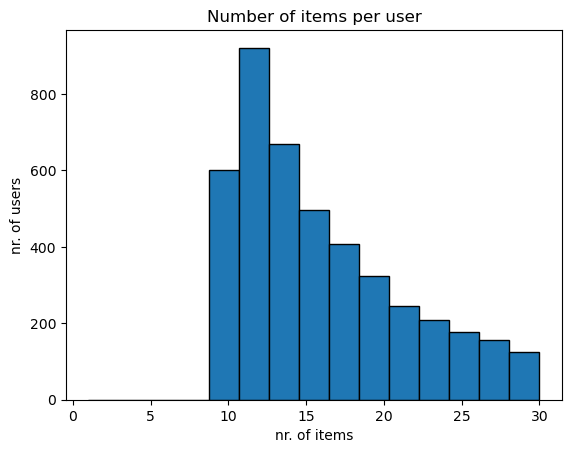

In [99]:
plt.hist(items_per_user['count'], bins=15, range=(1,30), edgecolor="black")
plt.xlabel("nr. of items")
plt.ylabel("nr. of users")
plt.title("Number of items per user")
plt.show()

In [100]:
df_main.select("item").dtypes

[('item', 'string')]

In [101]:
user_indexer = StringIndexer(inputCol="user", outputCol="userIndex").setHandleInvalid("keep")
item_indexer = StringIndexer(inputCol="item", outputCol="itemIndex").setHandleInvalid("keep")

df_main = user_indexer.fit(df_main).transform(df_main)
df_main = item_indexer.fit(df_main).transform(df_main)

In [102]:
df_main.printSchema()

root
 |-- item: string (nullable = true)
 |-- user: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- popularity: long (nullable = false)
 |-- num_items: long (nullable = false)
 |-- userIndex: double (nullable = false)
 |-- itemIndex: double (nullable = false)



In [103]:
df_main.select("itemIndex", "item").show()

+---------+--------------------+
|itemIndex|                item|
+---------+--------------------+
|    252.0|       The Gathering|
|    257.0|               Blood|
|    159.0|              Malice|
|   1652.0| Dancing in the Dark|
|   1171.0|               Bones|
|    298.0|                Lost|
|   1918.0|            Crucible|
|    205.0|               Honor|
|     36.0|            The Gift|
|   1041.0|No Rest for the W...|
|    310.0|                Lies|
|    440.0| Rules of Engagement|
|   1265.0|              Buried|
|     53.0|                 Red|
|    701.0|             Dominic|
|    732.0|                 Six|
|   1375.0|       Before I Wake|
|   1385.0|          Resolution|
|   1660.0|          Pitch Dark|
|     23.0|               Crave|
+---------+--------------------+
only showing top 20 rows



In [104]:
from pyspark.sql.functions import lit, first

In [105]:
df_final = df_main.select(
    col("itemIndex"),
    col("userIndex"),
    col("rating")
)

In [106]:
df_pandas = df_main.toPandas()

#### scikit-surprise

In [276]:
from surprise import Dataset, Reader, KNNWithMeans, BaselineOnly

In [109]:
reader = Reader(rating_scale=(1, 5))

In [110]:
df_pandas.head(20)

,item,user,rating,popularity,num_items,userIndex,itemIndex
0,Blood,Charlie ✰ WLTB Blog ✰,5.0,377,34,1460.0,257.0
1,Malice,Charlie ✰ WLTB Blog ✰,4.0,389,34,1460.0,159.0
2,Dancing in the Dark,Charlie ✰ WLTB Blog ✰,5.0,144,34,1460.0,1652.0
3,Ensnared,Charlie ✰ WLTB Blog ✰,4.0,176,34,1460.0,809.0
4,Murder,Charlie ✰ WLTB Blog ✰,4.0,143,34,1460.0,1702.0
5,Lost Boy,Charlie ✰ WLTB Blog ✰,4.0,126,34,1460.0,1721.0
6,Covet,Charlie ✰ WLTB Blog ✰,5.0,315,34,1460.0,200.0
7,Rules of Engagement,Charlie ✰ WLTB Blog ✰,5.0,190,34,1460.0,440.0
8,The Beast Within,Charlie ✰ WLTB Blog ✰,4.0,215,34,1460.0,736.0
9,No Rest for the Wicked,Charlie ✰ WLTB Blog ✰,5.0,183,34,1460.0,1041.0


In [111]:
df_data = Dataset.load_from_df(df_pandas[["userIndex", "itemIndex", "rating"]], reader)

In [112]:
df_data

In [114]:
# sim_options = {
#     "name": "cosine",
#     "user_based": False, # similarities between items
# }

In [115]:
# algo = KNNWithMeans(sim_options=sim_options)

### 7. Split to train and test 

In [242]:
trainingSet = df_data.build_full_trainset()

In [244]:
# View the number of users, items, and ratings
print(f"Number of users: {trainingSet.n_users}")
print(f"Number of items: {trainingSet.n_items}")
print(f"Number of ratings: {trainingSet.n_ratings}")

Number of users: 6006
Number of items: 2000
Number of ratings: 231516


In [246]:
for i, (uid, iid, rating) in enumerate(trainingSet.all_ratings()):
    if i < 10:
        print(f"User: {trainingSet.to_raw_uid(uid)}, Item: {trainingSet.to_raw_iid(iid)}, Rating: {rating}")

User: 1460.0, Item: 257.0, Rating: 5.0
User: 1460.0, Item: 159.0, Rating: 4.0
User: 1460.0, Item: 1652.0, Rating: 5.0
User: 1460.0, Item: 809.0, Rating: 4.0
User: 1460.0, Item: 1702.0, Rating: 4.0
User: 1460.0, Item: 1721.0, Rating: 4.0
User: 1460.0, Item: 200.0, Rating: 5.0
User: 1460.0, Item: 440.0, Rating: 5.0
User: 1460.0, Item: 736.0, Rating: 4.0
User: 1460.0, Item: 1041.0, Rating: 5.0


### 8. Collabortive filtering model

In [249]:
algo.fit(trainingSet)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [251]:
prediction = algo.predict(261.0, 1.0)

In [252]:
prediction.est

4.003394640393098

In [356]:
from surprise.model_selection import GridSearchCV

In [451]:
param_grid_knn = {
    'k': [20, 30, 40],
    'sim_options': {
        "name": ['msd', 'cosine', 'pearson'],
        "user_based": [True, False],
    }
}

In [453]:
# param_grid = {"param_grid_knn": param_grid_knn}

In [455]:
gs_knn = GridSearchCV(KNNWithMeans, param_grid_knn, measures=["rmse", "mae"], cv=3)

In [457]:
gs_knn.fit(df_data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similar

In [459]:
print(gs_knn.best_score["rmse"])

1.0530292438393354


In [461]:
print(gs_knn.best_params["rmse"])

{'k': 40, 'sim_options': {'name': 'msd', 'user_based': True}}


In [462]:
gs_knn.cv

3

In [463]:
results_df = pd.DataFrame(gs_knn.cv_results)
print(results_df.head())

   split0_test_rmse  split1_test_rmse  split2_test_rmse  mean_test_rmse  \
0          1.056375          1.055713          1.056661        1.056250   
1          1.064558          1.064436          1.068126        1.065707   
2          1.073630          1.072632          1.074949        1.073737   
3          1.068828          1.069669          1.073688        1.070728   
4          1.084653          1.087746          1.086209        1.086203   

   std_test_rmse  rank_test_rmse  split0_test_mae  split1_test_mae  \
0       0.000397               3         0.825165         0.823140   
1       0.001711               7         0.834870         0.834241   
2       0.000949              12         0.841041         0.838528   
3       0.002121              11         0.840337         0.841031   
4       0.001262              15         0.835635         0.836605   

   split2_test_mae  mean_test_mae  std_test_mae  rank_test_mae  mean_fit_time  \
0         0.823464       0.823923      0.000888

In [464]:
print(results_df.columns)

Index(['split0_test_rmse', 'split1_test_rmse', 'split2_test_rmse',
       'mean_test_rmse', 'std_test_rmse', 'rank_test_rmse', 'split0_test_mae',
       'split1_test_mae', 'split2_test_mae', 'mean_test_mae', 'std_test_mae',
       'rank_test_mae', 'mean_fit_time', 'std_fit_time', 'mean_test_time',
       'std_test_time', 'params', 'param_k', 'param_sim_options'],
      dtype='object')


In [465]:
import matplotlib.pyplot as plt
import seaborn as sns

In [466]:
results_df['param_sim_options'] = results_df['param_sim_options'].astype(str)


In [467]:
heatmap_data = results_df.pivot(index='param_k', columns='param_sim_options', values='mean_test_rmse')

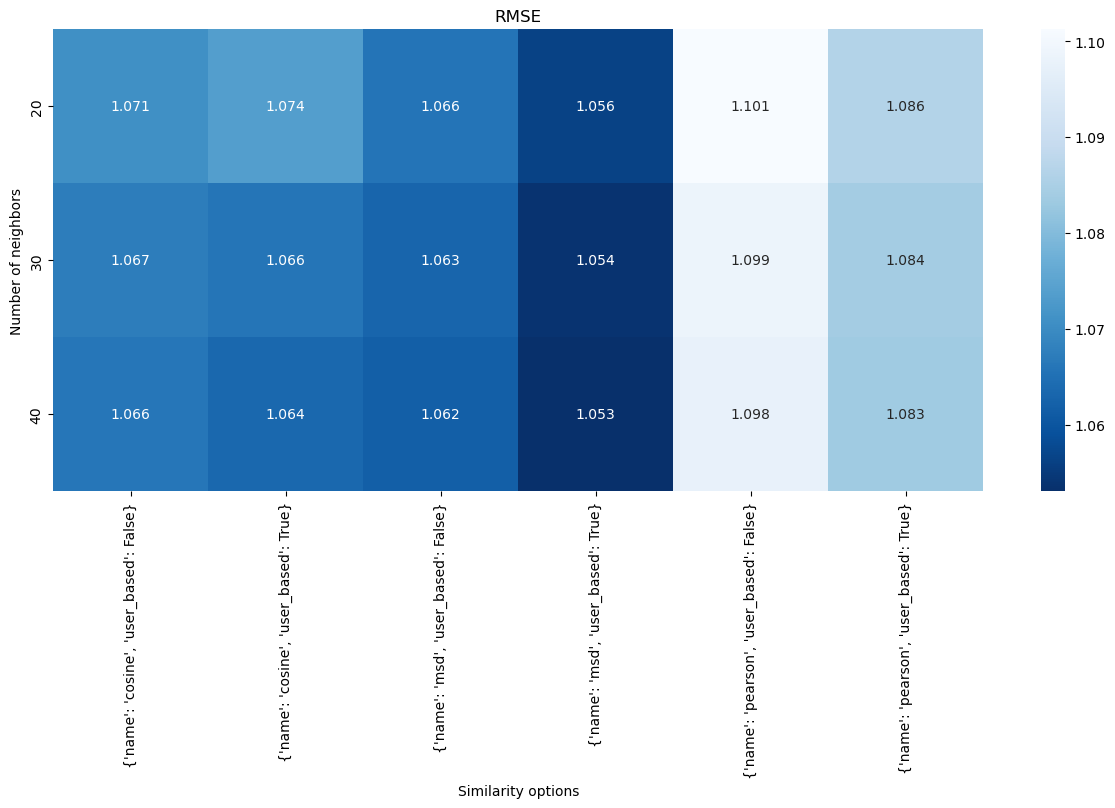

In [468]:
plt.figure(figsize=(15,6))
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='Blues_r')
plt.title('RMSE')
plt.xlabel('Similarity options')
plt.ylabel('Number of neighbors')
plt.show()

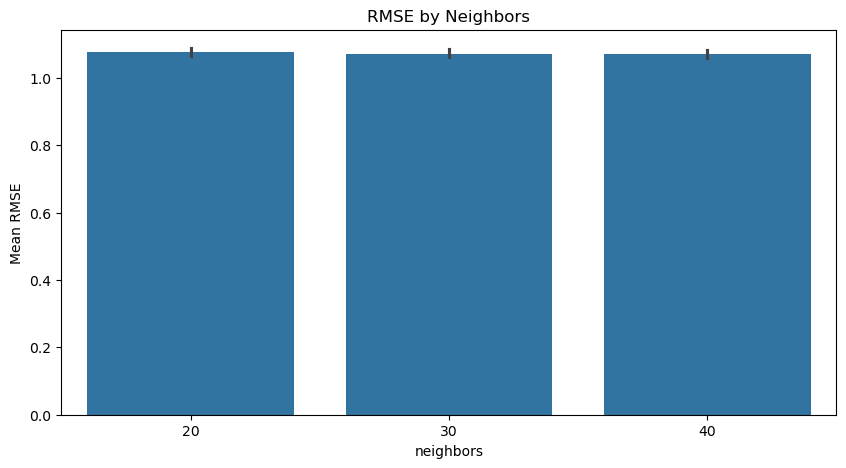

In [497]:
plt.figure(figsize=(10, 5))
sns.barplot(x='param_k', y='mean_test_rmse', data=results_df)
plt.title('RMSE by Neighbors')
plt.xlabel('neighbors')
plt.ylabel('Mean RMSE')
plt.show()
